In [1]:
##turn off the damn auto-bracketing, aparently it only needs to be done once
#from notebook.services.config import ConfigManager
#c = ConfigManager()
#c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})
import sys,os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style='ticks')
from scipy.interpolate import griddata as gd
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['lines.linewidth']   = 2
mpl.rcParams['axes.linewidth']    = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.labelsize']   = 10
mpl.rcParams['xtick.labelsize']   = 10
mpl.rcParams['axes.labelsize']    = 14
mpl.rcParams['legend.numpoints']  = 1
mpl.rcParams['axes.labelweight']  = 'semibold'
mpl.rcParams['axes.titlesize']    = 9
mpl.rcParams['axes.titleweight']  = 'semibold'
mpl.rcParams['font.weight']       = 'semibold'

datafile = 'conversion_data.csv'
datain  = pd.read_csv(datafile)
data = datain.to_records() ##A numpy recarray for later use
odata=data.copy()##a copy of the bare data recarray for bugshooting



#
##Seaborn pairplot autosupresses non-numerical coliumns, 
##so it makes life easier if converted is a string
qwe = np.where(datain.converted.values == 1)[0]
qwe2 =np.where(datain.converted.values == 0)[0]
datain['converted'] = datain['converted'].astype(str)
datain.converted.values[qwe] = 'Yes'
datain.converted.values[qwe2] = 'No' 
#print(datain.converted.values[qwe])
#print(datain.converted.values[qwe2])

#plt.hist(datain.total_pages_visited.values[qwe],bins=20,alpha=0.5,density=True)
#plt.hist(datain.total_pages_visited.values[qwe2],bins=20,alpha=0.5,density=True)
##Show me the column names, and an example entry
for cc in data.dtype.names: print(cc)
print data[0]

index
country
age
new_user
source
total_pages_visited
converted
(0, 'UK', 25, 1, 'Ads', 1, 0)


In [2]:
##breakdowns
print('Source Breakdown (%)')
print(datain['source'].value_counts()/len(datain)*100.0)
print('-----')
print('Country Breakdown (%)')
print(datain.country.value_counts()/len(datain)*100.0)
print('-----')
print('User Type (%)')
print(datain.new_user.value_counts()/len(datain)*100.0)


Source Breakdown (%)
Seo       49.032258
Ads       28.064516
Direct    22.903226
Name: source, dtype: float64
-----
Country Breakdown (%)
US         56.322581
China      24.225806
UK         15.322581
Germany     4.129032
Name: country, dtype: float64
-----
User Type (%)
1    68.54649
0    31.45351
Name: new_user, dtype: float64


<IPython.core.display.Javascript object>


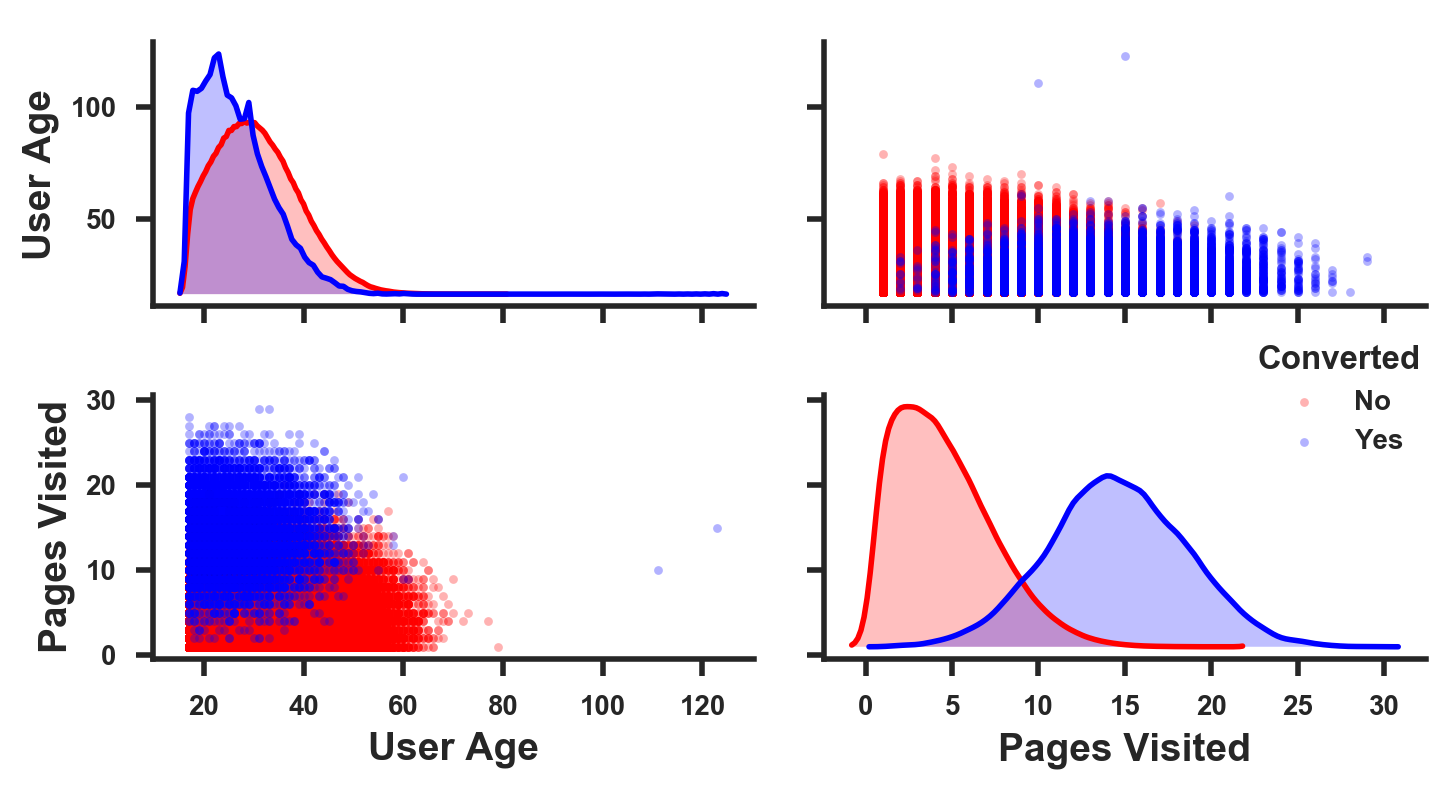

In [13]:
###Lets explore some things, breaking down the sample by whether or not people converted
plotcols = ['age','total_pages_visited','converted']
plotstuff = sns.pairplot(datain[plotcols],hue = 'converted', size=2, aspect=1.8,palette={'Yes': "b", 'No': "r"},diag_kind='kde',diag_kws=dict(shade=True,bw='0.6'),plot_kws=dict(edgecolor="black", linewidth=0.0,alpha=0.3,s=10))
plotstuff.axes[1,0].set_ylabel('Pages Visited')
plotstuff.axes[1,1].set_xlabel('Pages Visited')
plotstuff.axes[0,0].set_ylabel('User Age')
plotstuff.axes[1,0].set_xlabel('User Age')
plotstuff._legend.set_title('Converted')

### First Impressions Age and Page Numbers
1. There are two super old folks in this dataset, that are outliers in terms of any statistical inferences we would like to make. Excluding them might be a good idea prior to making a model to predict conversion rate. <br>
2. People who bought something (converted=Yes) seem to visit significantly more pages than those who did not. This might be correlated in the other direction though poeple wo are going to buy might look at lots of pages after making the buy desicion (e.g. to see/compare versions of a product?)
3. Older people tend to both convert less often, and look at less pages

Total Conversion Rate: 3.22%


<IPython.core.display.Javascript object>


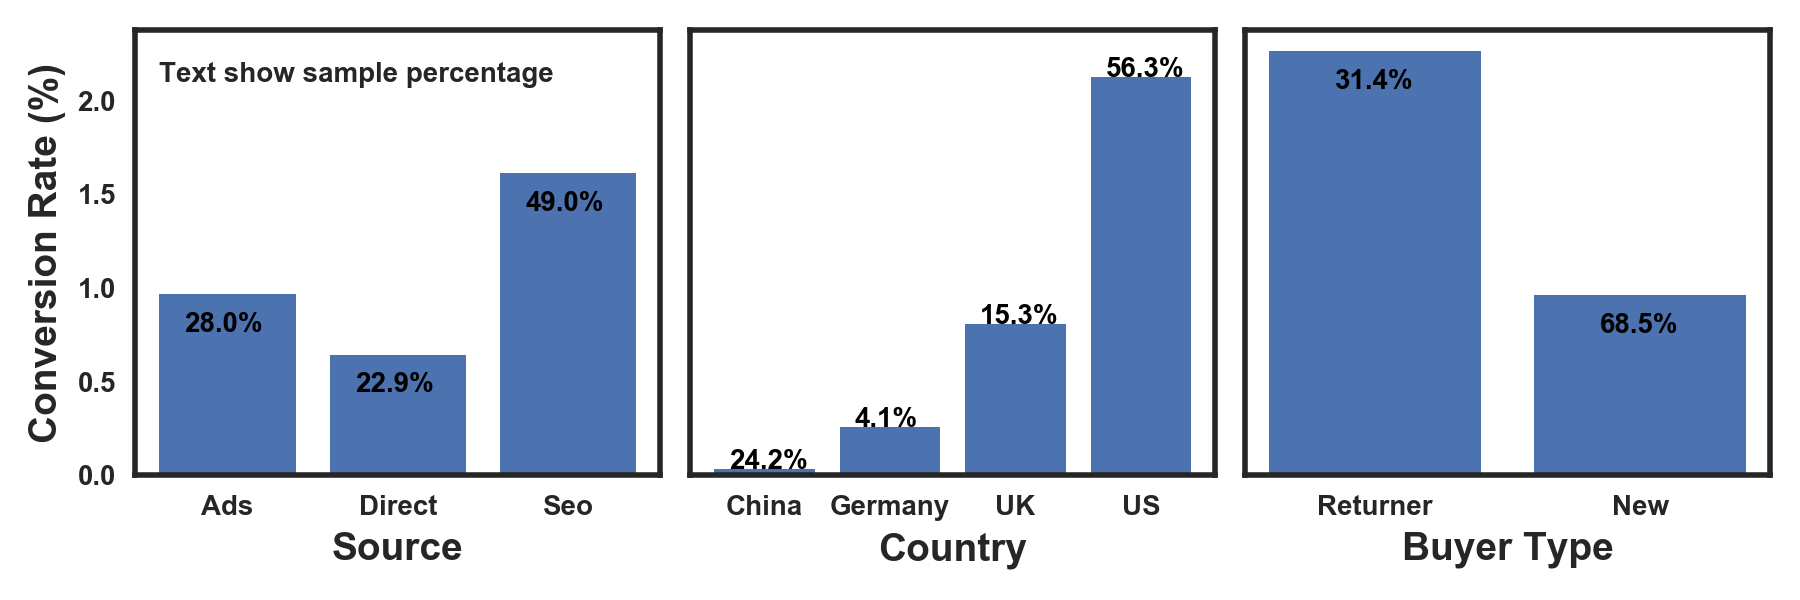

In [28]:
##Lets plot the other categorical variables as bar plots, and see how they stack up towards converstion.

#counterplot = sns.countplot(x='source', hue='converted', data=datain, palette={'Yes': 'b', 'No': 'r'})
cc = np.where(datain.converted.values == 'Yes')[0]
nc = np.where(datain.converted.values == 'No')[0]
print('Total Conversion Rate: ' +str(len(cc)*1.0/len(datain)*100)[0:4] + '%')

##Source
x_values = [xx for xx in np.unique(datain.source.values)]
y_values = [len(np.where(datain.source.values[cc] == xx)[0])*1.0/len(datain)*100.0 for xx in x_values]

fig,(ax0,ax1,ax2) = plt.subplots(1,3,figsize=(9, 3),sharey=True)
ax0.bar(x_values,y_values)
ax0.set_ylabel('Conversion Rate (%)')
ax0.set_xlabel('Source')

for idx,ii in enumerate(ax0.patches):
    qwe = np.where(datain.source == x_values[idx])[0]
    ax0.text(ii.get_x()+0.15, ii.get_height()-0.2,str(len(qwe)*1.0/len(datain)*100)[0:4]+'%', fontsize=10,color='black')

##Country
x_values = [xx for xx in np.unique(datain.country.values)]
y_values = [len(np.where(datain.country.values[cc] == xx)[0])*1.0/len(datain)*100.0 for xx in x_values]

#fig2,ax2 = plt.subplots()
ax1.bar(x_values,y_values)
#ax1.set_ylabel('Conversion Rate (%)')
ax1.set_xlabel('Country')
for idx,ii in enumerate(ax1.patches):
    qwe = np.where(datain.country == x_values[idx])[0]
    ax1.text(ii.get_x()+0.12, ii.get_height(),str(np.round(len(qwe)*1.0/len(datain)*100,decimals=1))+'%', fontsize=10,color='black')

##User Type
x_values = [xx  for xx in np.unique(datain.new_user.values)]
y_values = [len(np.where(datain.new_user.values[cc] == xx)[0])*1.0/len(datain)*100.0 for xx in x_values]
nx_values = ['Returner','New']

#fig3,ax3 = plt.subplots()
ax2.bar(nx_values,y_values)
#ax2.set_ylabel('Conversion Rate (%)')
ax2.set_xlabel('Buyer Type')
for idx,ii in enumerate(ax2.patches):
    qwe = np.where(datain.new_user == x_values[idx])[0]
    ax2.text(ii.get_x()+0.25, ii.get_height()-0.2,str(len(qwe)*1.0/len(datain)*100)[0:4]+'%', fontsize=10,color='black')
ax0.text(-0.4,2.1,'Text show sample percentage')
fig.tight_layout()

### Impressions from Source, Country and Buyer Type
1. It seems like Conversion rate strongly correlates with the nationality of the User with users. This is a problem because Chinese customers are a significant proportio of the users (~24%) while showing a very low conversion rate. Similarly, German/UK users seem to convert more often but are a relatively small percantage of the user base. 
2. Returning customers are approximately twice as likely to convert that new costomers
3. Seo source customers seem to be more likely to convert that the other sources, they are also approximately half of the user base
<br>
Are there correlations between these?
### We can make a model to predict conversion using a Niave Bayes classifier. 
Start with cleaning some outliers, then index categorical data to make it easier to use

In [16]:
##there are two super old folks in here, both new customers, exclude as they are not useful for any real insight
##going to use the recarray version here so I don't have to type values all the time.
oldies = np.where(data.age > 90.0)[0] ##The two old users are above 100
clean = np.where(data.age < 90.)[0]
data=data[clean]

In [17]:
##Flag converted and non-converted entries for later use.
conv  = np.where(data.converted == 1)[0]
nconv = np.where(data.converted == 0)[0]

In [18]:
##lets index the categorical string type fields: source and country
sources   = np.unique(data.source)
sdict = dict(zip(sources,range(len(sources))))
countries = np.unique(data.country)
cdict = dict(zip(countries,range(len(countries))))
sindex = np.zeros(len(data),dtype=int)
cindex = np.zeros(len(data),dtype=int)
for i in range(len(data)):
    cindex[i] = cdict[data.country[i]]
    sindex[i] = sdict[data.source[i]]
    
print(cdict)
print(sdict)


{'Germany': 1, 'China': 0, 'US': 3, 'UK': 2}
{'Seo': 2, 'Ads': 0, 'Direct': 1}


### Lets make the Niave Bayes model. 
We can turn it into a non-niave Bayes model later if we want by sample an N-dimensional histogram, probably not needed though.

For each case in $$C_i$$ representing the cases for conversion and non-conversion<br>
we can calculate the probability using Bayes theorem.
$$P(C_i|Data) = P(C_i)P(Data|C_i)/P(Data)$$

with $$P(Data|C_i) = P(age|C_i)P(pages|C_i)P(Country|C_i)P(Source|C_i)P(NewUser|C_i)$$

Then the model likelihood ratio (converted to not-converted) is 
$$R = \frac{P(Conv)P(Data|Conv)}{P(NConv)P(Data|NConv)}$$

with the prior ratio $$\frac{P(Conv)}{P(Nconv)} $$ given by the global conversion rate

The probabilities for the categorical data are simple frequencies, and for the numerical fields (age, number of pages), we can use the histograms as estimates of the distribution PDF's. We could parametrize them, e.g. converted page numbers looks close to Gaussian, but the other distributions are definitely not that simple. 

To make things slightly simpler again, testing points that fall outside of the bin ranges of our training set histograms will be assigned to the edge bins. This means points that would get zero probabilit will get a small probability. This is an ok approximation for now, but would be a problem if we needed to predict conversion for things well outside the bounds of the training set data.

In [19]:

def prob_data_given_model(histage,histpage,cind,sind,new_user,testpoint):
    '''
    Training Set Data:
    
    histage and histpage are 2 element tuples, which are the output of the numpy histogram functions on the 
    user age and page visits data.
    
    cind and sind are the training set country and source indexes
    new_user is the user type flag of the training set data
    
    testpoint is a list of parameters of a point you want the probability of conversion for.
    [age,country,source,newuser,numpages]
    
    '''
    ##make the age histogram first
    agehist,agebins = histage
    ##compute the component probabilities:
    ad = agebins-testpoint[0]
    closest = np.where(ad <= 0)[0]
    if len(closest) == 0: 
        closest = 0
    else: closest = closest[-1]
    if closest > len(agehist)-1: closest = -1
    p_age_model = agehist[closest]

    p_country_model = len(np.where(cind == testpoint[1])[0])*1.0/len(cind)

    p_source_model  = len(np.where(sind == testpoint[2])[0])*1.0/len(sind)
    
    p_new_model = len(np.where(new_user == testpoint[3])[0])*1.0/len(new_user)
    
    ##make page visit histogram:
    pagehist,pagebins = histpage
    
    pd = pagebins - testpoint[4]
    
    closest = np.where(pd <= 0)[0]
    if len(closest) == 0: 
        closest = 0
    else: closest = closest[-1]
    if closest > len(pagehist)-1: closest = -1
    
    p_page_model = pagehist[closest]
    
    return p_page_model*p_new_model*p_source_model*p_country_model*p_age_model


    

In [23]:
## run a test point through the model
global_prior = len(conv)*1.0/len(data)
print('Prior ' + str(global_prior))

tpoint = [20,3,0,0,15] ##age,country,source,newuser,pages
##This testpoint should convert given the young age, source locatoin and large page numbers.
prob_given_conv = prob_data_given_model(np.histogram(data.age[conv],bins=20,density=True),np.histogram(data.total_pages_visited[conv],bins=15,density=True),cindex[conv],sindex[conv],data.new_user[conv],tpoint)

prob_given_nconv  = prob_data_given_model(np.histogram(data.age[nconv],bins=20,density=True),np.histogram(data.total_pages_visited[nconv],bins=15,density=True),cindex[nconv],sindex[nconv],data.new_user[nconv],tpoint)

model_lk_rat = prob_given_conv/prob_given_nconv*global_prior
print('prob(D|model convert): ' + str(prob_given_conv))
print('prob(D|model noconvert): ' + str(prob_given_nconv))
print('model likelihood ratio (convert/not_convert): ' + str(model_lk_rat)[0:5])
print('probability of conversion: ' + str(model_lk_rat/(1+model_lk_rat)*100)[0:4] + '%')




Prior 0.0322519434026
prob(D|model convert): 0.0007670278682950353
prob(D|model noconvert): 2.0797166606070067e-06
model likelihood ratio (convert/not_convert): 11.89
probability of conversion: 92.2%


### Test the model:
We will use two thirds of the initial dataset as a training sample, and the remaining third as a testing set.
<br>
##### Note we only run this next code block once to save time, skip ahead!

In [33]:
##seems like randomizing ins't really needed here
#makechoice = np.random.choice(len(data.index),len(data.index),replace=False)

trainset = np.array(range(int(len(data)/3.0*2.0)))
testset  = np.array(range(int(len(data)/3.0*2.0),len(data)))
tc = np.where(data.converted[trainset] == 1)[0]
tn = np.where(data.converted[trainset] == 0)[0]
prior = len(tc)*1.0/len(trainset)

histage_conv = np.histogram(data.age[trainset[tc]],bins=20,density=True)
histage_nconv = np.histogram(data.age[trainset[tn]],bins=20,density=True)
histpage_conv = np.histogram(data.total_pages_visited[trainset[tc]],bins=15,density=True)
histpage_nconv = np.histogram(data.total_pages_visited[trainset[tn]],bins=15,density=True)

convprob = np.zeros(len(testset),dtype=float)
for i in range(0,len(testset)):
    if i % 1000 == 0 : 
        print('Up to ' + str(i) + ' out of '  + str(len(testset)))
        sys.stdout.flush()
    tpoint = [data.age[testset[i]],cindex[testset[i]],sindex[testset[i]],data.new_user[testset[i]],data.total_pages_visited[testset[i]]]
    prob_given_conv = prob_data_given_model(histage_conv,histpage_conv,cindex[trainset[tc]],sindex[trainset[tc]],data.new_user[trainset[tc]],tpoint)
    prob_given_nconv  = prob_data_given_model(histage_nconv,histpage_nconv,cindex[trainset[tn]],sindex[trainset[tn]],data.new_user[trainset[tn]],tpoint)

    model_lk_rat = prob_given_conv/prob_given_nconv*prior
    convprob[i] = model_lk_rat/(1+model_lk_rat)
#print(convprob)

Up to 0 out of 105400
Up to 1000 out of 105400
Up to 2000 out of 105400


KeyboardInterrupt: 

In [24]:
##save the results and the testing set for time saving later
import pickle
fff = open('tmp_modelsave','rb')
#pickle.dump((testset,convprob),fff)
testset,convprob = pickle.load(fff)
fff.close()


### How good is the model?
We can use the testing set (the last third of the original dataset) to estimate this.<br>
First, set a cutoff probability of conversion, lets say 50% conversion probability, we can then see what fraction of the test set we correctly classified.

In [26]:
cutoff = 0.5
modc = np.where(convprob >= cutoff)[0]
modnc =np.where(convprob < cutoff)[0]
assignment = np.zeros(len(testset),dtype=int)
assignment[modc] = 1
qwe = np.where(assignment - data[testset].converted == 0)[0]

print('Model Assignment Accuracy: ' + str(np.around(len(qwe)*1.0/len(testset)*100,decimals=2)) + '%')

Model Assignment Accuracy: 98.59%


/Users/acr2877/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


<IPython.core.display.Javascript object>


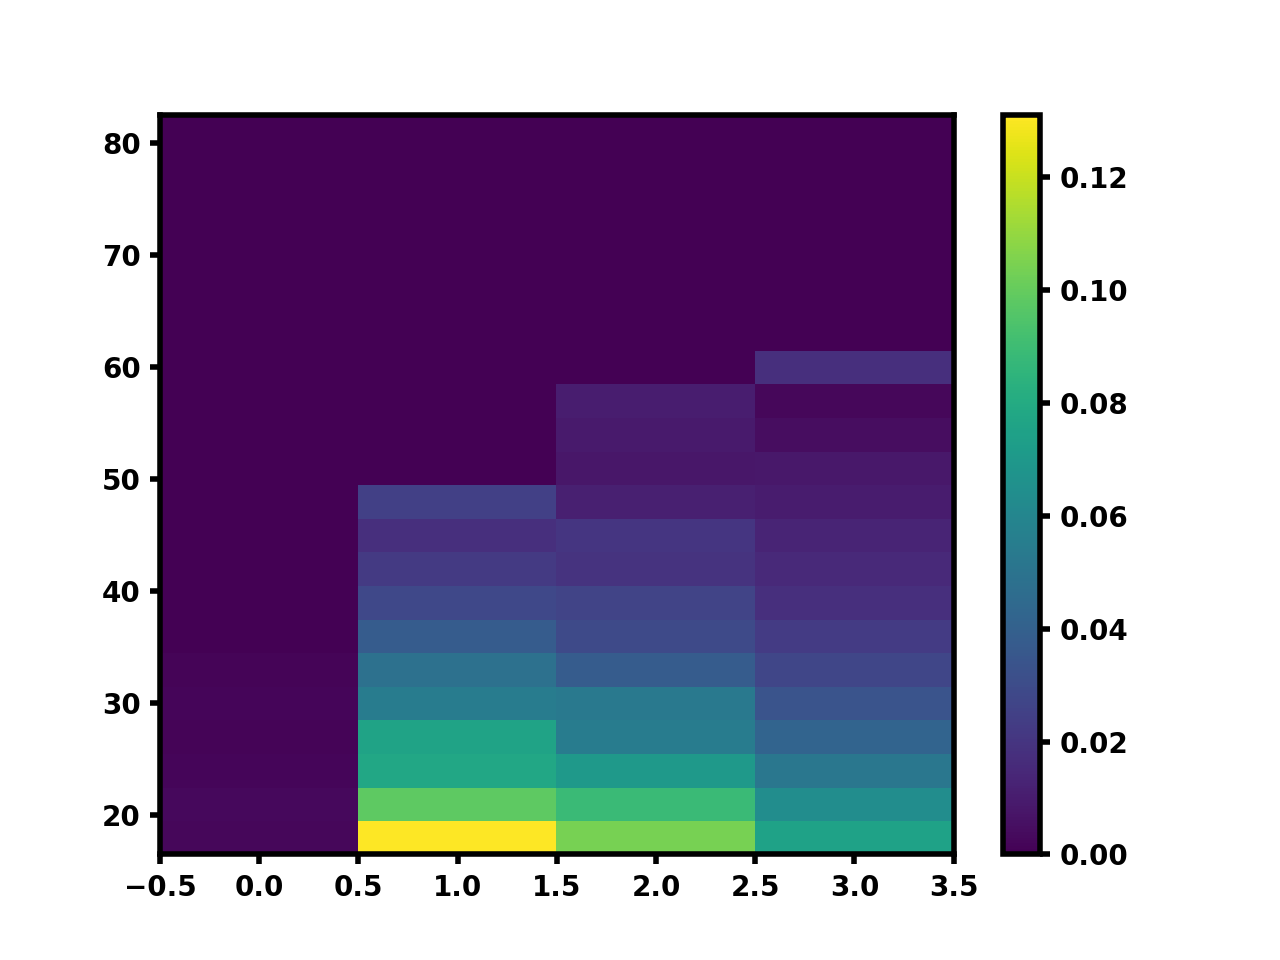

23
(22, 4)
[0.05970081 0.02637501 0.13104089]


In [75]:
##define bin edges
interpsize=[3,1]
agebins = np.arange(16.5,83.5,interpsize[0])
cbins = np.arange(-0.5,4.5,interpsize[1])

##make an nD histogram for conerted and not converted
chist_inputs = (data.age[conv].astype(float),cindex[conv].astype(float))
hconv,hedges = np.histogramdd(chist_inputs,bins=(agebins,cbins))

allhist_inputs = (data.age.astype(float),cindex.astype(float))
hall,alledges = np.histogramdd(allhist_inputs,bins=(agebins,cbins))
qwe = np.where(hall == 0)[0]
hcrate= hconv/hall
hcrate[qwe] = 0.0
#print(alledges[1]-hedges[1])


fig,ax = plt.subplots()
aa = ax.pcolormesh(alledges[1][0:],alledges[0][0:],hcrate)#,cmap='cubehelix')
fig.colorbar(aa)
plt.show()

print(len(alledges[0]))
print(hcrate.shape)
##now interpolate from this for a given value
from scipy.interpolate import RegularGridInterpolator
interpolator = RegularGridInterpolator((alledges[0][0:len(alledges[0])-1]+interpsize[0]/2.0,alledges[1][0:len(alledges[1])-1]+interpsize[1]/2.0),hcrate)
tester = np.array([[22.0,40.0,18.0],[3.0,1.0,1.0]]).T
test_out = interpolator(tester)
print(test_out)





In [27]:
nums,bins= np.histogram(data.age,density=False,weights=data.converted,bins=50)
nums2,bins2 = np.histogram(data.age,density=False,bins=50)
#print(nums.astype(float)/nums2.astype(float))
plt.plot(bins[1:],nums.astype(float)/nums2)
plt.xlabel('Age')
plt.ylabel('Conversion Rate')
plt.xlim([17,80])
plt.ylim([0.0,0.1])
plt.show()

/Users/acr2877/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


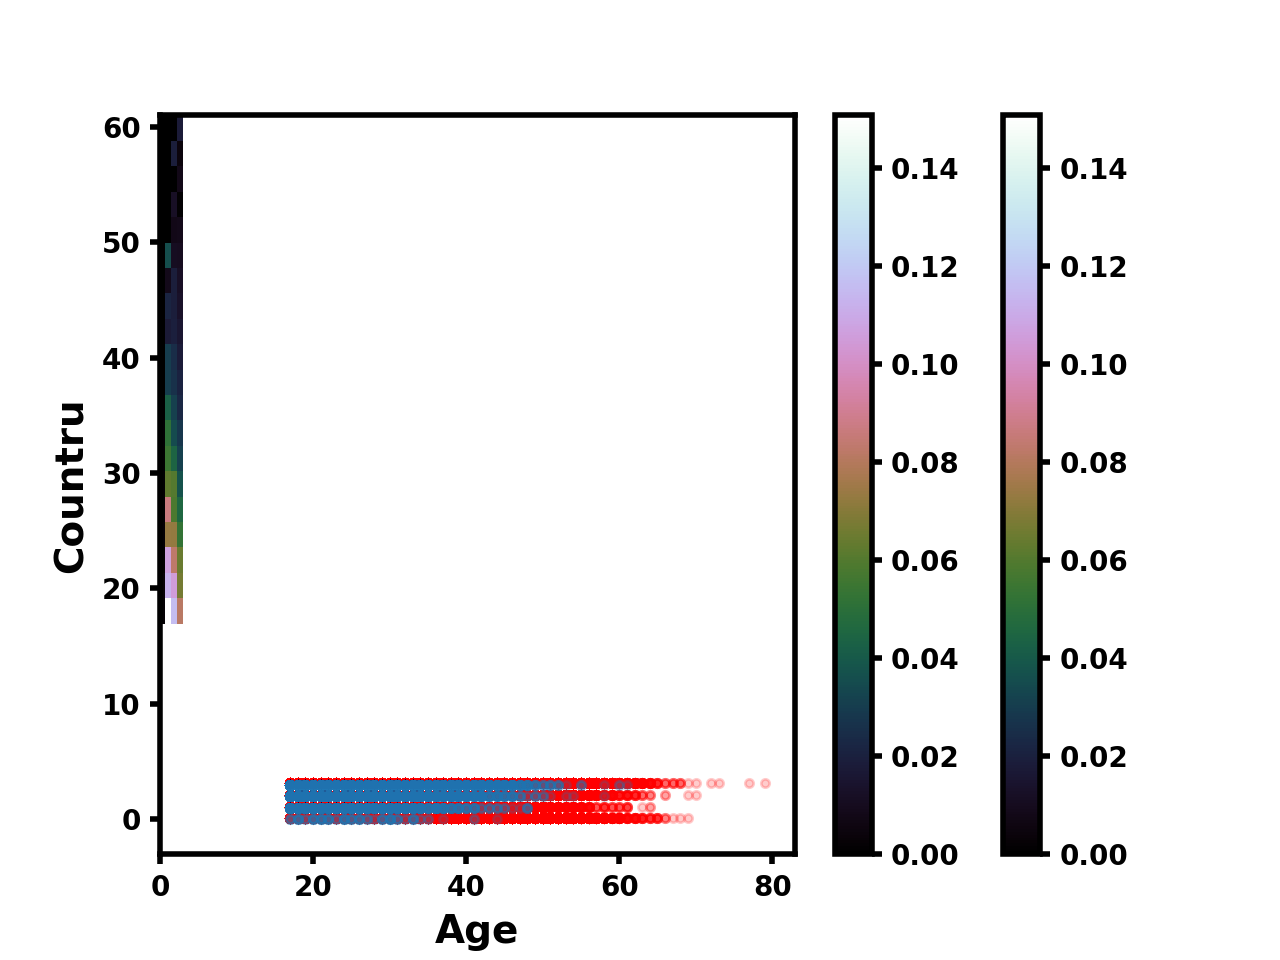

In [36]:
fig,ax=plt.subplots()
ax.plot(data.age[nconv],cindex[nconv]+0.1,'.r',alpha=0.2)
ax.plot(data.age[conv],cindex[conv],'.',alpha=0.2)
ax.set_ylabel('Countru')
ax.set_xlabel('Age')

plt.show()


<IPython.core.display.Javascript object>


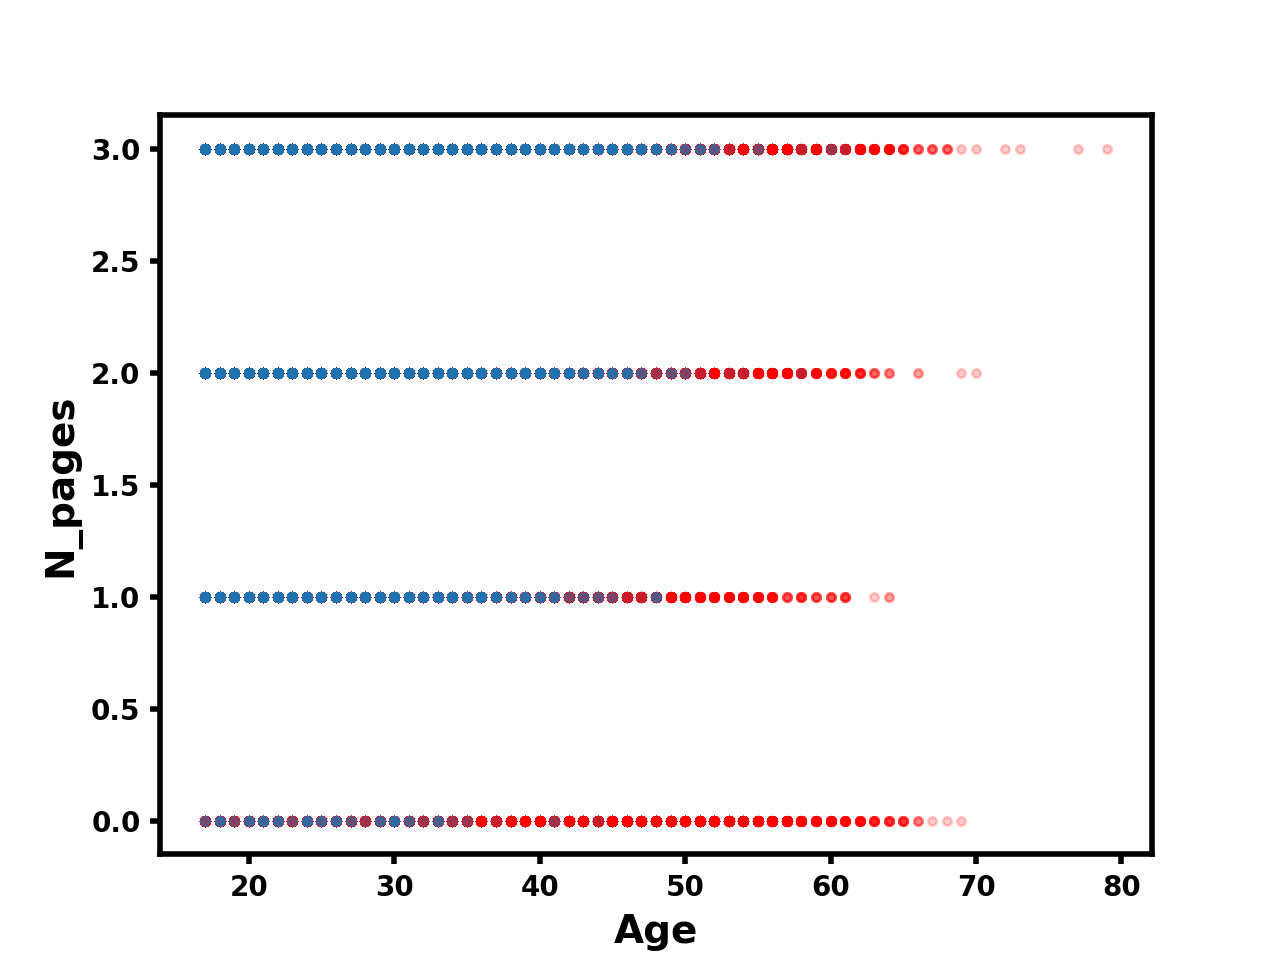

Text(0.5,0,'Age')

In [31]:
fig,ax=plt.subplots()
ax.plot(data.age[nconv],cindex[nconv],'.r',alpha=0.2)
ax.plot(data.age[conv],cindex[conv],'.',alpha=0.2)
ax.set_ylabel('N_pages')
ax.set_xlabel('Age')

In [ ]:
##interpolate with grid_data

